# Self-Driving Car Engineer Nanodegree


## Project: Advanced Lane Line Tracking

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

1. Camera Calibration
    1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
    2. Apply a distortion correction to raw images
2. Color Space & Gradient Processing
    1. Use color transforms in HLS to extract useful color/level data   
    2. Use gradients with Sobel operator and thresholding for a binary image
    3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Detect lane pixels and fit to find the lane boundary.
     1. Determine the curvature of the lane and vehicle position with respect to center.
     2. Warp the detected lane boundaries back onto the original image.
     3. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
   
5. Video Processing Pipeline   
     1. Image undistort
     2. Color transform (use S-channel)
     3. Gradient detector for edges
     4. Perspective transform to dewarp camera image
     5. Lane detect using historical tracking data
     6. Calcualte curvature metrics
     7. Warp back to original image geometry
***





## 0. Initializations

### Import Packages

In [24]:
#Importing packages required for notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from IPython.display import Markdown
import cv2
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed
%matplotlib inline


print("Packages imported ...")

# References & Citations
# Color Thresholding: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
# Function Architecture & Video Text Overlays: https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md
# https://github.com/jeremy-shannon/CarND-Advanced-Lane-Lines/blob/master/project.ipynb
# https://github.com/darienmt/CarND-Advanced-Lane-Lines-P4

Packages imported ...


## 1. Camera Calibration

Use checkerboard images to calibrate camera intrinsics. 
* Load reference calibration images
* Detect checkerboard corners for _valid_ images & calibrate camera sensor
* Undistort images using calibration matrix (instrinsics)

- - - - 

### 1.1 Calibration Using Checkerboard Patterns

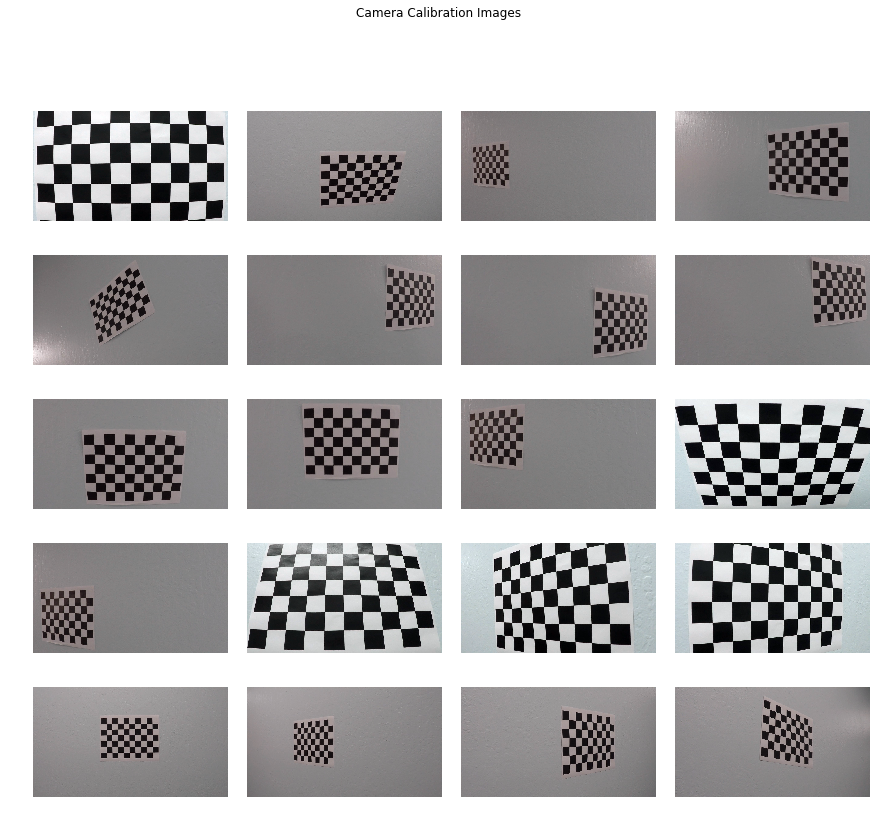

In [2]:
# Load calibration images in a list
calibrationImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), glob.glob('./Resources/camera_cal/c*.jpg')))
# Display camera clibration images 
def showImages(images, cols = 4, rows = 5, figsize=(15,2)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    plt.suptitle('Camera Calibration Images')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    #plt.tight_layout()
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            ax.imshow(image)
            #ax.set_title(imagePathName)
            ax.axis('off')

cols = 4
rows = int(len(calibrationImages)/cols)
showImages(calibrationImages, cols, rows, (15, 13))

Calibration images with corner found: 17


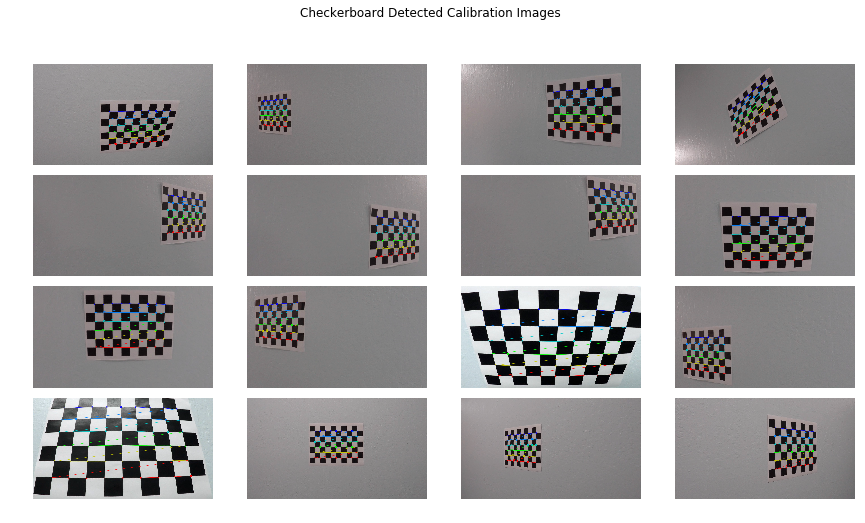

In [3]:
# Checkerboard patterns: 10x7 squares

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
outimages = []
originalImages = []

# Make a list of calibration images
images = glob.glob('./Resources/camera_cal/c*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    
        # Draw and display the corners
        img_points = cv2.drawChessboardCorners(img.copy(), (9,6), corners, ret)
        outimages.append(img_points)
        originalImages.append(img)
        
print('Calibration images with corner found: {}'.format(len(outimages)))
imgLength = len(outimages)
rows = 4
cols = int(len(outimages)/rows)
fig, axes = plt.subplots(rows, cols, figsize=(15,8))
plt.suptitle('Checkerboard Detected Calibration Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):
    ax.imshow(outimages[index])
    ax.axis('off')


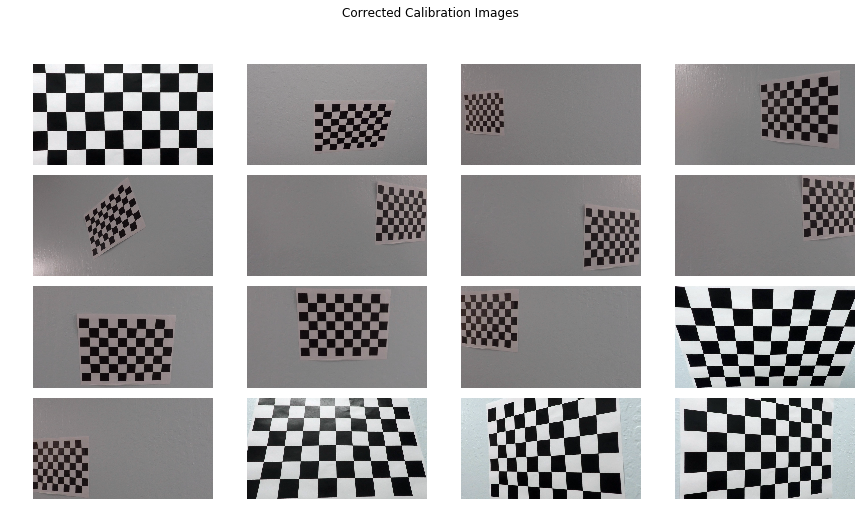

In [4]:
images = glob.glob('./Resources/camera_cal/c*.jpg')
files = os.listdir("./Resources/camera_cal/")
undistort_images = []

# Step through the list and search for calibration images
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort based on calibration matrix
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('Resources/camera_cal_undistort/'+files[idx], dst) 
    undistort_images.append(dst)

imgLength = len(outimages)
rows = 4
cols = int(len(outimages)/rows)
fig, axes = plt.subplots(rows, cols, figsize=(15,8))
plt.suptitle('Corrected Calibration Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):
    ax.imshow(undistort_images[index])
    ax.axis('off')
    

In [5]:
# Save Camera Calibration Data
pickle.dump( { 'mtx': mtx, 'dist': dist }, open('./pickled_data/camera_calibration.p', 'wb'))
print("Saved camera calibration data to file ...")

Saved camera calibration data to file ...


### 1.2 Undistort Images

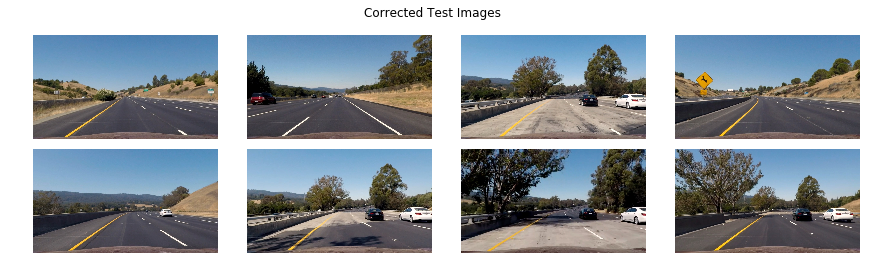

In [6]:
# Process test images and apply undistort processing; save in folder  

files = os.listdir("./Resources/test_images/")
undistort_images = []

# Step through the list and search for calibration images
for idx, fname in enumerate(files):
    img = cv2.imread("./Resources/test_images/"+fname)
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort based on calibration matrix
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('Resources/test_images_undistort/'+files[idx], dst) 
    undistort_images.append(dst)

imgLength = len(undistort_images)
rows = 2
cols = int(len(undistort_images)/rows)
fig, axes = plt.subplots(rows, cols, figsize=(15,4))
plt.suptitle('Corrected Test Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):    
    ax.imshow(cv2.cvtColor(undistort_images[index], cv2.COLOR_BGR2RGB))
    ax.axis('off')


-----

## 2. Color Space & Gradient Processing

Process undistorted images using camera calibration matrix. 
* Use color transforms in HLS to extract useful color/level data (H & S-channel)  
* Also try R-channel from RGB to reliably detect yellow & white lane markers
* Use gradients with Sobel operator and thresholding for a binary image
- - - -

### 2.1 Color Space Conversion

Some experimentation across image data-sets shows that H, S and R components may be reliably used under very general lighting and shadow conditions for lane marker extraction. 
A transformed color space image stack is generated using the R, H & S components for further threshold and gradient processing. 

"\n# plot HLS images per component\nrows = len(hls_undistort_images)\ncols = 3\nfig, axes = plt.subplots(rows, cols, figsize=(15,24))\nplt.suptitle('HLS Test Images')\nplt.subplots_adjust(wspace=0.1, hspace=0.1)\n#plt.tight_layout()\nindexes = range(cols * rows)\nfor ax, index in zip(axes.flat, indexes):    \n    chidx = int(np.mod(index,3))\n    picidx = int(index/3)\n    ax.imshow(hls_undistort_images[picidx][:,:,chidx], cmap='gray')\n    ax.axis('off')\n\n# plot RGB images per component\nrows = len(rgb_undistort_images)\ncols = 3\nfig, axes = plt.subplots(rows, cols, figsize=(15,24))\nplt.suptitle('RGB Test Images')\nplt.subplots_adjust(wspace=0.1, hspace=0.1)\n#plt.tight_layout()\nindexes = range(cols * rows)\nfor ax, index in zip(axes.flat, indexes):    \n    chidx = int(np.mod(index,3))\n    picidx = int(index/3)\n    ax.imshow(rgb_undistort_images[picidx][:,:,chidx], cmap='gray')\n    ax.axis('off')\n\n\n# plot RLS images per component\nrows = len(rgb_undistort_images)\ncols = 3

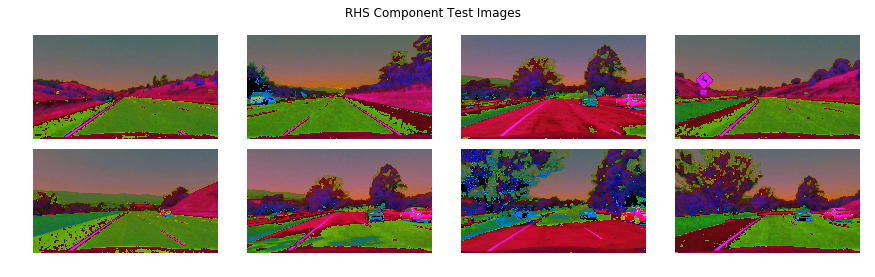

In [7]:
# Convert undistorted test images to HLS and display
files = os.listdir("./Resources/test_images_undistort/")
hls_undistort_images = []
rgb_undistort_images = []
rhs_undistort_images = []

# Step through the list and search for calibration images
for idx, fname in enumerate(files):
    img = cv2.imread("./Resources/test_images_undistort/"+fname)
    # Undistort based on calibration matrix
    hls_undistort_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2HLS))
    cv2.imwrite("./Resources/test_images_undistort_hls/"+fname, hls_undistort_images[idx])
    rgb_undistort_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    cv2.imwrite("./Resources/test_images_undistort_rgb/"+fname, rgb_undistort_images[idx])
    # Generate RHS component image stack for further processing
    # Stack each channel to view their individual contributions in R(ed), H(ue) and S(aturation) componenets respectively
    rhs_image = np.dstack(( rgb_undistort_images[idx][:,:,0], hls_undistort_images[idx][:,:,0], hls_undistort_images[idx][:,:,2]))
    rhs_undistort_images.append(rhs_image)
    cv2.imwrite("./Resources/test_images_undistort_rhs/"+fname, rhs_image)

# Plot RHS componenet images
imgLength = len(rhs_undistort_images)
rows = 2
cols = int(len(rhs_undistort_images)/rows)
fig, axes = plt.subplots(rows, cols, figsize=(15,4))
plt.suptitle('RHS Component Test Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):    
    ax.imshow(rhs_undistort_images[index], cmap='gray')
    ax.axis('off')

    
"""
# plot HLS images per component
rows = len(hls_undistort_images)
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15,24))
plt.suptitle('HLS Test Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):    
    chidx = int(np.mod(index,3))
    picidx = int(index/3)
    ax.imshow(hls_undistort_images[picidx][:,:,chidx], cmap='gray')
    ax.axis('off')

# plot RGB images per component
rows = len(rgb_undistort_images)
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15,24))
plt.suptitle('RGB Test Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):    
    chidx = int(np.mod(index,3))
    picidx = int(index/3)
    ax.imshow(rgb_undistort_images[picidx][:,:,chidx], cmap='gray')
    ax.axis('off')


# plot RLS images per component
rows = len(rgb_undistort_images)
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15,24))
plt.suptitle('RHS Test Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):    
    chidx = int(np.mod(index,3))
    picidx = int(index/3)
    if chidx == 0: # R
        ax.imshow(rgb_undistort_images[picidx][:,:,chidx], cmap='gray')
    elif chidx == 1: # H
        ax.imshow(hls_undistort_images[picidx][:,:,chidx-1], cmap='gray')
    else:# chidx == 2: # S
        ax.imshow(hls_undistort_images[picidx][:,:,chidx], cmap='gray')
    ax.axis('off')
"""    

### 2.2 Color & Gradient Thresholding

#### 2.2.1 Color Thresholding (RGB + HLS + Lab)
Using white & yellow thresholding on RGB images with the following component thresholds. 

| Color | Space | Min Threshold | Max Threshold |
|-:|-:|-:|-:|
|White|RGB|[100, 100, 200]|[255, 255, 255]|
|Yellow|RGB|[225, 180, 0]|[255, 255, 170]|
|Yellow|HLS|[20, 120, 100]|[45, 200, 255]|
|Yellow|Lab|[0, 0, 154]|[0, 0, 255]|

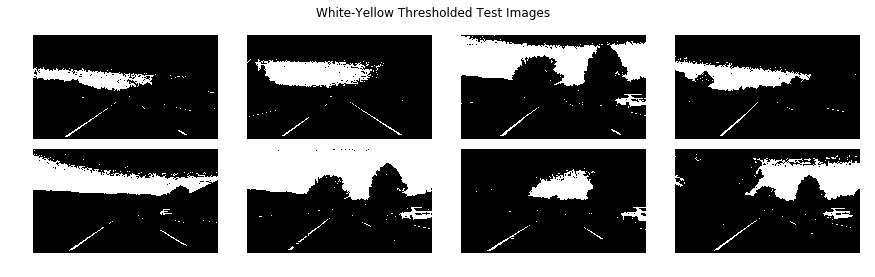

interactive(children=(IntSlider(value=127, description='min_s_thresh', max=255), IntSlider(value=127, descript…

<function __main__.update(min_s_thresh, max_s_thresh)>

In [22]:
# Threhsold white & yellow colors from RGB & HLS component spaces
files = os.listdir("./Resources/test_images_undistort/")
whiteyellow_undistort_images = []

# Step through the list and search for calibration images
for idx, fname in enumerate(files):
    img = cv2.imread("./Resources/test_images_undistort/"+fname)
    # Color space transforms
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    # RGB, HLS & Lab color thresholds for yellow & white 
    # combined yellow & white thresholds
    lowrgb_white = np.array([100,100,200], dtype = "uint8")
    highrgb_white = np.array([255,255,255], dtype = "uint8")
    lowrgb_yellow = np.array([255,180,0], dtype = "uint8")
    highrgb_yellow = np.array([255,255,170], dtype = "uint8")
    lowhls_yellow = np.array([20,120,130], dtype = "uint8")
    highhls_yellow = np.array([45,200,255], dtype = "uint8")
    lowlab_yellow = np.array([0,0,154], dtype = "uint8")
    highlab_yellow = np.array([0,0,255], dtype = "uint8")
    
    # RGB white
    mask = cv2.inRange(img_rgb, lowrgb_white, highrgb_white)
    rgb_ww = cv2.bitwise_and(img_rgb, img_rgb, mask = mask).astype(np.uint8)
    rgb_ww = cv2.cvtColor(rgb_ww, cv2.COLOR_RGB2GRAY)
    rgb_w = np.zeros_like(rgb_ww)
    rgb_w[(rgb_ww >= 80) & (rgb_ww <= 255)] = 1
    
    # RGB yellow
    mask = cv2.inRange(img_rgb, lowrgb_yellow, highrgb_yellow)
    rgb_yy = cv2.bitwise_and(img_rgb, img_rgb, mask = mask).astype(np.uint8)
    rgb_yy = cv2.cvtColor(rgb_yy, cv2.COLOR_RGB2GRAY)
    rgb_y = np.zeros_like(rgb_yy)
    rgb_y[(rgb_yy >= 20) & (rgb_yy <= 255)] = 1

    # HLS yellow
    mask = cv2.inRange(img_hls, lowhls_yellow, highhls_yellow)
    hls_yy = cv2.bitwise_and(img_hls, img_hls, mask = mask).astype(np.uint8)
    hls_yy = cv2.cvtColor(hls_yy, cv2.COLOR_HLS2RGB)
    hls_yy = cv2.cvtColor(hls_yy, cv2.COLOR_RGB2GRAY)
    hls_y = np.zeros_like(hls_yy)
    hls_y[(hls_yy >= 50) & (hls_yy <= 255)] = 1

    # Lab yellow
    mask = cv2.inRange(img_lab, lowlab_yellow, highlab_yellow)
    lab_yy = cv2.bitwise_and(img_lab, img_lab, mask = mask).astype(np.uint8)
    lab_yy = cv2.cvtColor(lab_yy, cv2.COLOR_HLS2RGB)
    lab_yy = cv2.cvtColor(lab_yy, cv2.COLOR_RGB2GRAY)
    lab_y = np.zeros_like(lab_yy)
    lab_y[(lab_yy >= 50) & (lab_yy <= 255)] = 1

    # combined yellow+white thresholds
    bin_whiteyellow = np.zeros_like(hls_y)
    bin_whiteyellow[(hls_y == 1) | (rgb_y == 1) | (rgb_w == 1) | (lab_y == 1)] = 255
    #bin_whiteyellow[((hls_y == 1) | (lab_y == 1)) | (rgb_w == 1)] = 255
    
    whiteyellow_undistort_images.append(bin_whiteyellow)
    cv2.imwrite("./Resources/test_images_undistort_whiteyellow/"+fname, bin_whiteyellow)
    
# Plot white-yellow thresholded binary images
imgLength = len(whiteyellow_undistort_images)
rows = 2
cols = int(len(whiteyellow_undistort_images)/rows)
fig, axes = plt.subplots(rows, cols, figsize=(15,4))
plt.suptitle('White-Yellow Thresholded Test Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):    
    ax.imshow(whiteyellow_undistort_images[index], cmap='gray')
    ax.axis('off')
    
    
# interactive threshold selector     
def hsv_sthresh(img, thresh=(80,255)):
    # 1) Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_s = hsv[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hsv_s)
    binary_output[((hsv_s > thresh[0]) & (hsv_s <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output
def update(min_s_thresh, max_s_thresh):
    exampleImg_HSVThresh = hsv_sthresh(img, (min_s_thresh, max_s_thresh))
    # Visualize HSV S threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_HSVThresh, cmap='gray')
    ax2.set_title('HSV S-channel', fontsize=30)

files = os.listdir("./Resources/test_images_undistort/")
img = cv2.imread("./Resources/test_images_undistort/"+files[0])
    
interact(update,
         min_s_thresh=(0,255),
         max_s_thresh=(0,255))



##### 2.2.1.1 Lab Color Space Exploration
Using B-channel to extract yellow color from image frame. Chosen trhesholds can be selected with an interactive exploration of the right values that work across all selected test image sets. 

In [21]:
def lab_bthresh(img, thresh=(154,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def update(min_b_thresh, max_b_thresh):
    exampleImg_LBThresh = lab_bthresh(img, (min_b_thresh, max_b_thresh))
    # Visualize LAB B threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_LBThresh, cmap='gray')
    ax2.set_title('LAB B-channel', fontsize=30)

files = os.listdir("./Resources/test_images_undistort/")
img = cv2.imread("./Resources/test_images_undistort/"+files[0])
    
interact(update,
         min_b_thresh=(0,255),
         max_b_thresh=(0,255))


interactive(children=(IntSlider(value=127, description='min_b_thresh', max=255), IntSlider(value=127, descript…

<function __main__.update(min_b_thresh, max_b_thresh)>

#### 2.2.1 Color Thresholding (RHS)
With the RHS componenet image, we threshold each channel to detec the yellow & white components reliably. The following thresholds have been used after some limited trials with thresholds based on *a priori* understanding of thd RGB & HLS color spaces.  

| Component | Min Threshold | Max Threshold |
|-:|-:|-:|
|R|90|145|
|H|20|45|
|S|80|255|

Applying these thresholds to the RHS image stack and converting to a binary signal for each component results in the following test image output. This demonstrates the the relevance of the color-space components chosen as well as the threshold choice in determining the lane markers reliably.     

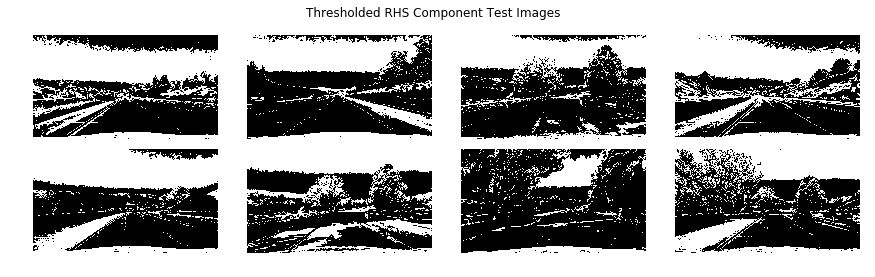

In [10]:
# Generate binary thresholded RHS componenet images
files = os.listdir("./Resources/test_images_undistort/")
rhs_binary_images = []
r_thresh_min = 90
r_thresh_max = 145
h_thresh_min = 20
h_thresh_max = 45
s_thresh_min = 80
s_thresh_max = 255
for idx, fname in enumerate(files):
    r_channel = rhs_undistort_images[idx][:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
    h_channel = rhs_undistort_images[idx][:,:,1]
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1
    s_channel = rhs_undistort_images[idx][:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    rhs_image = np.dstack(( r_binary, h_binary, s_binary))*255
    rhs_binary_images.append(rhs_image)
    
    cv2.imwrite("./Resources/test_images_binary_rhs/"+fname, rhs_binary_images[idx])

# Plot binary thresholded RHS component images
imgLength = len(rhs_binary_images)
rows = 2
cols = int(len(rhs_binary_images)/rows)
fig, axes = plt.subplots(rows, cols, figsize=(15,4))
plt.suptitle('Thresholded RHS Component Test Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):    
    ax.imshow(rhs_binary_images[index][:,:,0], cmap='gray')
    #ax.imshow(rhs_binary_images[index][:,:,2], cmap='gray')
    ax.axis('off')


#### 2.2.2 RoI Mask

Before applying edge gradient thresholding, mask out the parts of image frame that are not likley to be lane marker edges. In order to still account for extreme lane curvatures, make sure to keep those parts of the image that  span the entire width. 

In [37]:
def roi_mask (img, maskfit_factor_horiz=3.1, maskfit_factor_vert=1.8):
    # define region of interest, 4-sided polygon
    ysize = img.shape[0]
    xsize = img.shape[1]
    offset_height = ysize/4 # 1/4th bottom is always kept unmasked
    left_end = np.array([0, ysize])
    right_end = np.array([xsize, ysize])
    left_bottom = np.array([0, ysize-offset_height])
    right_bottom = np.array([xsize, ysize-offset_height])
    # check ROI top vertices don't cross
    if (xsize/maskfit_factor_horiz < xsize/2):
        left_top = np.array([xsize/maskfit_factor_horiz, ysize/maskfit_factor_vert])
        right_top = np.array([xsize-xsize/maskfit_factor_horiz, ysize/maskfit_factor_vert])
    else:
        left_top = np.array([xsize/2, ysize/maskfit_factor_vert])
        right_top = np.array([xsize/2, ysize/maskfit_factor_vert])
    roi_vertices = np.array([[left_end,left_bottom,left_top,right_top,right_bottom,right_end]], dtype=np.int32)
    
    # apply mask
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, roi_vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    img = cv2.bitwise_and(img, mask)
    window_img = np.zeros_like(img)
    cv2.fillPoly(window_img, roi_vertices, (0,255,0))
    result = cv2.addWeighted(img, 1, window_img, 0.3, 0)

    return result

def update(horiz_factor, vert_factor):
    out_img = roi_mask (img, horiz_factor, vert_factor)
    # Visualize RoI masked images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Full Binary Image', fontsize=30)
    ax2.imshow(out_img, cmap='gray')
    ax2.set_title('RoI Masked Image', fontsize=30)

files = os.listdir("./Resources/test_images_undistort_whiteyellow/")
img = cv2.imread("./Resources/test_images_undistort_whiteyellow/"+files[0])
    
interact(update,
         horiz_factor=(1.,5),
         vert_factor=(1.,5))

interactive(children=(FloatSlider(value=3.0, description='horiz_factor', max=5.0, min=1.0), FloatSlider(value=…

<function __main__.update(horiz_factor, vert_factor)>

#### 2.2.3 Gradient Thresholding

Sobel edge detection schemes with gradient thresholding using absolute contrast gradient values as well as angle/magnitude thresholding was tested.

Further testing with a Laplacian operator on the R, H and S-channels with a combination strategy showed more robust edge detection especially with some tuned thresholds as below.

>*Laplacian edge filter settings for RHS channels*: 
`kernel_size=5, abs_thresh=(100, 150), mag_thresh=(20, 200), angle_thresh=(0.5, np.pi/2))`

>*RHS threshold combination strategy*: 
`out = ((R_thresholded & H_thresholded) | S_thresholded)`

Recursive gradient thresholding was tried to refine edge detection and reduce noise in the detected contrast gradients. In the end, a simple large kernel gradient threshold scheming that selected between magnitude/angle and absolute gradient values was chosen and the former didnt show a marked improvement over the simpler implementation.  

A test between "sobel" and "laplacian" edge operators shows no visible diffference in the detected edges for color-thresholded frames. We have selected the "laplacian" with a tuned choice of threshold metrics to detect the most robust edges in the binary image frame. 

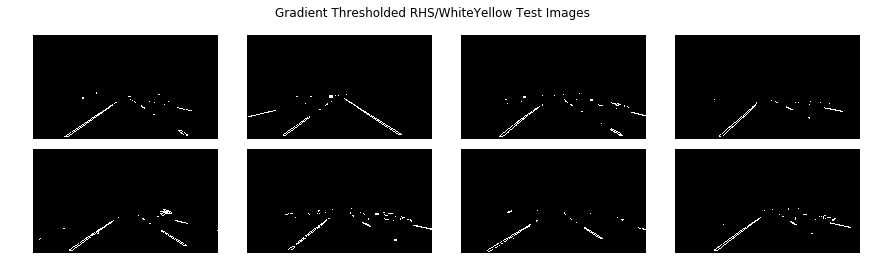

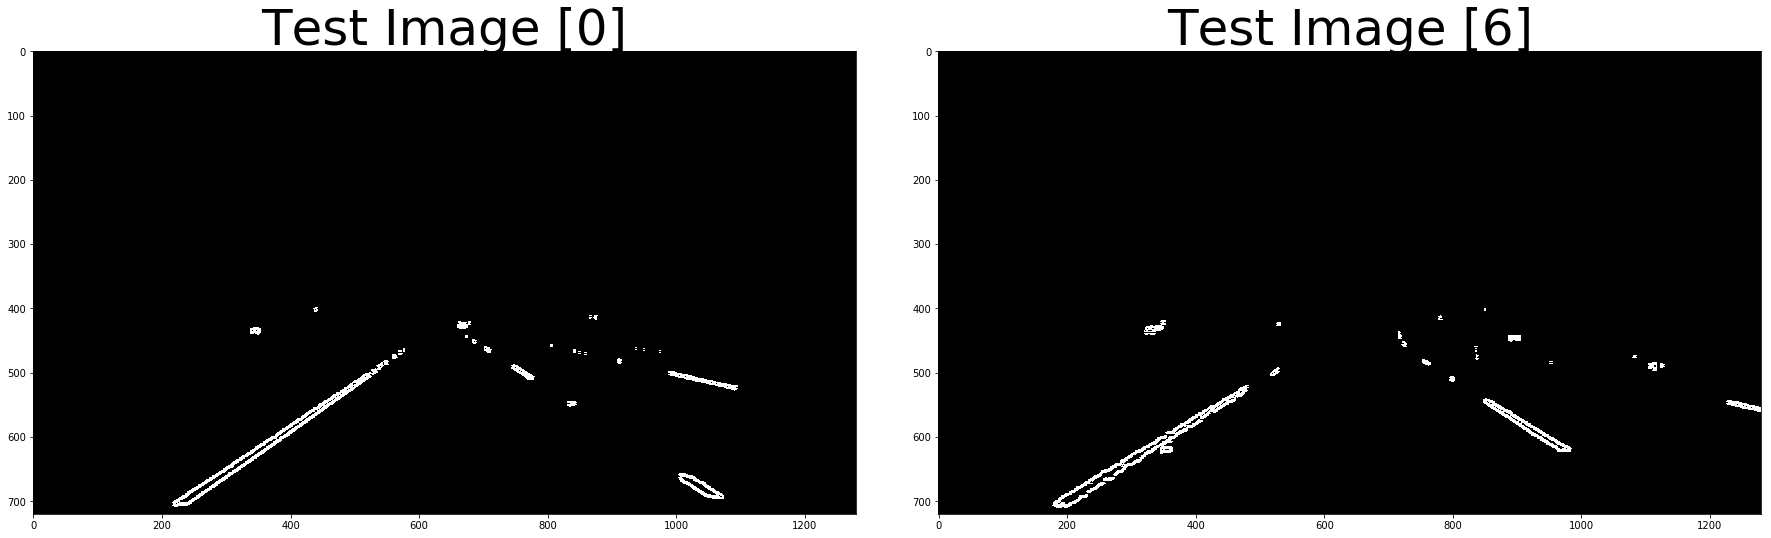

interactive(children=(IntSlider(value=0, description='edge_selector', max=1), Output()), _dom_classes=('widget…

<function __main__.update(edge_selector)>

In [42]:
# Process RHS component images 
#  apply Sobel/Laplacian gradient thresholding (absolute, magnitude & angle)
def pipeline(s_channel, filter_type="sobel", kernel_size=5, abs_thresh=(0, 255), mag_thresh=(0, 255), angle_thresh=(0, np.pi/2)):
    
    # absolute thresholding
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if (filter_type == "sobel"):
        sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=kernel_size)
        sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=kernel_size)
    else: #"laplacian"
        sobelx = cv2.Laplacian(s_channel, cv2.CV_64F, ksize=kernel_size)
        sobely = cv2.Laplacian(s_channel, cv2.CV_64F, ksize=kernel_size)
    # Rescale back to 8 bit integer
    scaled_sobelx = np.uint8(255*np.absolute(sobelx)/np.max(np.absolute(sobelx)))
    scaled_sobely = np.uint8(255*np.absolute(sobely)/np.max(np.absolute(sobely)))
    # Create a copy and apply the threshold
    abs_binary_x = np.zeros_like(scaled_sobelx)
    abs_binary_y = np.zeros_like(scaled_sobely)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    abs_binary_x[(scaled_sobelx >= abs_thresh[0]) & (scaled_sobelx <= abs_thresh[1])] = 1
    abs_binary_y[(scaled_sobely >= abs_thresh[0]) & (scaled_sobely <= abs_thresh[1])] = 1

    # magnitude thresholding
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # angle thresholding
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= angle_thresh[0]) & (absgraddir <= angle_thresh[1])] = 1

    # generate combined thresholded S-channel image
    combined = np.zeros_like(dir_binary)
    combined[((abs_binary_x == 1) & (abs_binary_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255

    return combined
    
#files = os.listdir("./Resources/test_images_binary_rhs/")
files = os.listdir("./Resources/test_images_undistort_whiteyellow/")
gradient_rhs_images = []
# Step through the list and apply gradient thresholding pipeline
for idx, fname in enumerate(files):
    #img = cv2.imread("./Resources/test_images_binary_rhs/"+fname)
    img = cv2.imread("./Resources/test_images_undistort_whiteyellow/"+fname)
    """
    # select RHS component to process {0:R, 1:H, 2:S}
    chidx = 0
    resultR = pipeline(img[:,:,chidx], filter_type="laplacian", abs_thresh=(20, 160), mag_thresh=(20, 160), angle_thresh=(0.5, np.pi/2))
    chidx = 1
    resultH = pipeline(img[:,:,chidx], filter_type="laplacian", abs_thresh=(20, 160), mag_thresh=(20, 160), angle_thresh=(0.5, np.pi/2))
    chidx = 2
    resultS = pipeline(img[:,:,chidx], filter_type="laplacian", abs_thresh=(20, 160), mag_thresh=(20, 160), angle_thresh=(0.5, np.pi/2))
    result = np.zeros_like(resultS)
    result[((resultR == 255) & (resultH == 255)) | (resultS == 255)] = 255
    """
    
    #
    # Apply RoI mask
    #
    img = roi_mask(img)
    
    # select RHS component to process {0:R, 1:H, 2:S}
    chidx = 2
    result = pipeline(img[:,:,chidx], filter_type="sobel", kernel_size=7, abs_thresh=(30, 255), mag_thresh=(20, 255), angle_thresh=(0.5, np.pi/2))
    #result = pipeline(result, kernel_size=5, abs_thresh=(160, 160), mag_thresh=(20, 160), angle_thresh=(0.5, np.pi/2))
    gradient_rhs_images.append(result)
    cv2.imwrite("./Resources/test_images_gradient_rhs_grad/"+fname, gradient_rhs_images[idx])
    
# Plot the result
cols = 4
rows = int(len(gradient_rhs_images)/cols)
fig, axes = plt.subplots(rows, cols, figsize=(15,4))
plt.suptitle('Gradient Thresholded RHS/WhiteYellow Test Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):    
    ax.imshow(gradient_rhs_images[index], cmap='gray')
    ax.axis('off')

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
f.subplots_adjust(wspace=0.1, hspace=0.1)
ax1.imshow(gradient_rhs_images[0], cmap='gray')
ax1.set_title('Test Image [0]', fontsize=50)
ax2.imshow(gradient_rhs_images[6], cmap='gray')
ax2.set_title('Test Image [6]', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    


# interactive sobel/laplacian selector     
def update(edge_selector):
    roiimg = roi_mask(img)
    if (edge_selector == 0):
        result = pipeline(roiimg[:,:,chidx], filter_type="sobel", kernel_size=7, abs_thresh=(30, 255), mag_thresh=(20, 255), angle_thresh=(0.5, np.pi/2))
    else:
        result = pipeline(roiimg[:,:,chidx], filter_type="laplacian", kernel_size=7, abs_thresh=(30, 255), mag_thresh=(20, 255), angle_thresh=(0.5, np.pi/2))
    # Visualize gradient threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img[:,:,chidx], cmap='gray')
    ax1.set_title('Gradient Edge Image', fontsize=30)
    ax2.imshow(result, cmap='gray')
    ax2.set_title('RoI Masked Edge Selector [0:sobel, 1:laplacian]', fontsize=30)

files = os.listdir("./Resources/test_images_undistort_whiteyellow/")
img = cv2.imread("./Resources/test_images_undistort_whiteyellow/"+files[6])
    
interact(update, edge_selector=(0, 1))



### 2.3 De-warp Using Perspective Transform

* Manually mark warped rectangle on one test image (selected) 
* Apply CV2 function to get warp matrix and pickle the data

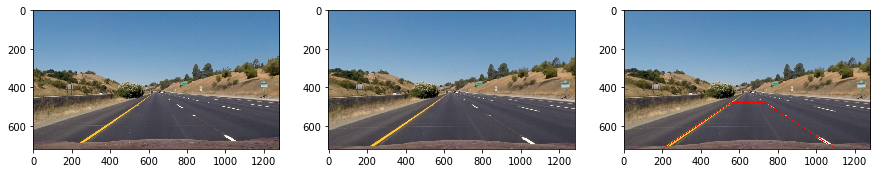

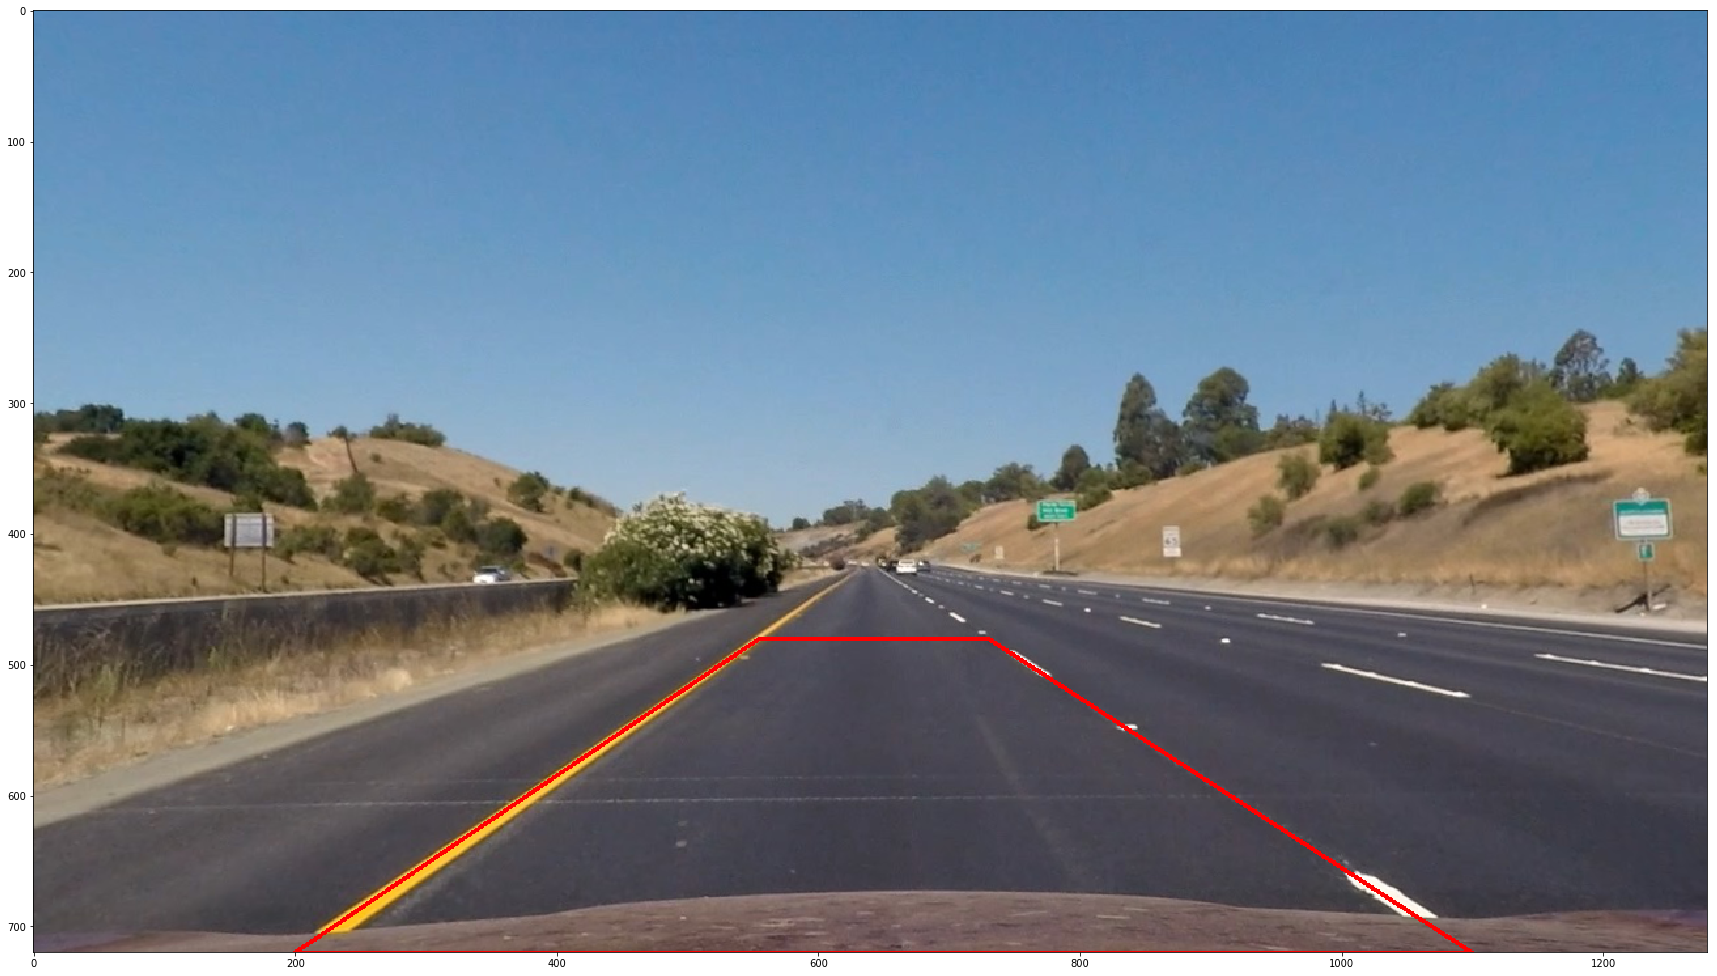

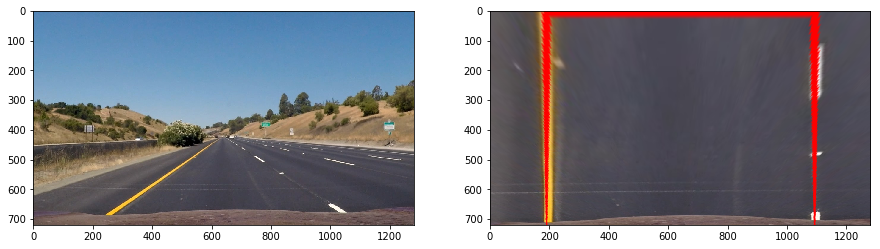

In [12]:
# Loading camera calibration
cameraCalibration = pickle.load( open('./Resources/pickled_data/camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

# Select test image to measure warp matrix 'M' with (using 'straight_lines1.jpg')
img = cv2.imread('Resources/test_images\straight_lines1.jpg')

undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
fig= plt.subplots(ncols=3, figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(undistort_img,cv2.COLOR_BGR2RGB))

#  Mark warped rectangle boundaries & use to geenrate warp matrix 
xSize, ySize, _ = undistort_img.shape
copy = undistort_img.copy()
bottomY = 720
topY = 480#440
left1 = (200, bottomY)
left1_x, left1_y = left1
left2 = (555, topY) #612
left2_x, left2_y = left2
right1 = (730, topY) #668
right1_x, right1_y = right1
right2 = (1100, bottomY)
right2_x, right2_y = right2
color = [0, 0, 255]
w = 2
cv2.line(copy, left1, left2, color, w)
cv2.line(copy, left2, right1, color, w)
cv2.line(copy, right1, right2, color, w)
cv2.line(copy, right2, left1, color, w)
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(copy,cv2.COLOR_BGR2RGB))

plt.figure(figsize=(30,20))
plt.imshow(cv2.cvtColor(copy,cv2.COLOR_BGR2RGB))
#  Undistort using calibration matrices

#
gray = cv2.cvtColor(undistort_img, cv2.COLOR_BGR2GRAY)
src = np.float32([ 
    [left2_x, left2_y],
    [right1_x, right1_y],
    [right2_x, right2_y],
    [left1_x, left1_y]
])
nX = gray.shape[1]
nY = gray.shape[0]
img_size = (nX, nY)
offset = 190
dst = np.float32([
    [offset, 0],
    [img_size[0]-offset, 0],
    [img_size[0]-offset, img_size[1]], 
    [offset, img_size[1]]
])
img_size = (gray.shape[1], gray.shape[0])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(copy, M, img_size)
fig= plt.subplots(ncols=2, figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))


# save warp matrix
pickle.dump( { 'M': M, 'Minv': Minv }, open('./Resources/pickled_data/perspective_transform.p', 'wb'))

#### 2.3.1 Warp the Gradient Thresholded RHS Images

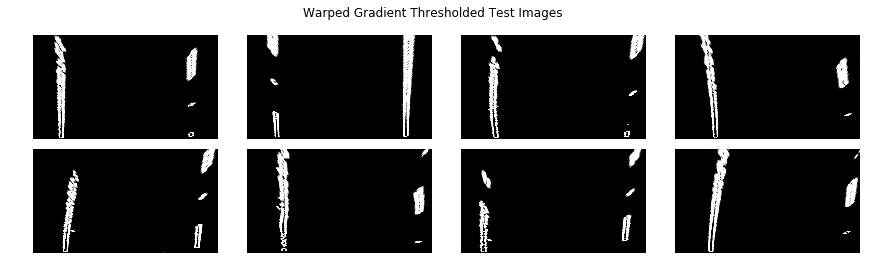

In [43]:
# read gradient thresholded HLS images
# use "S-channel" for futher processing
transMatrix = pickle.load( open('./Resources/pickled_data/perspective_transform.p', 'rb' ) )
M, Minv = map(transMatrix.get, ('M', 'Minv'))

files = os.listdir("./Resources/test_images_gradient_rhs_grad/")
ofiles = os.listdir("./Resources/test_images/")
warped_gradient_rhs_undistort_images = []
original_images = []

# Step through the list and search for calibration images
for idx, fname in enumerate(files): 
    img = cv2.imread("./Resources/test_images_gradient_rhs_grad/"+fname)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    warped_gradient_rhs_undistort_images.append(warped)
    cv2.imwrite("./Resources/test_images_warped_gradient_binary/"+fname, warped)
    oimg = cv2.imread("./Resources/test_images/"+fname)
    original_images.append(oimg)

# Plot the result
cols = 4
rows = int(len(warped_gradient_rhs_undistort_images)/cols)
fig, axes = plt.subplots(rows, cols, figsize=(15,4))
plt.suptitle('Warped Gradient Thresholded Test Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = cols * rows
for ax, index in zip(axes.flat, range(0,indexes)):    
    ax.imshow(cv2.cvtColor(warped_gradient_rhs_undistort_images[index],cv2.COLOR_BGR2RGB), cmap="gray")
    ax.axis('off')


_______

## 3. Lane Boundary Detection

* Histogram peak line detect
* Line tracking over frame using sliding window & convolution search algorithm
* Measure curvature and car body center markers

** Tracking Lines from prior detection **
> 1. Sliding Window Histogram Search
> 2. Cross-correlation Peak Search

### 3.2 Histogram Based Search


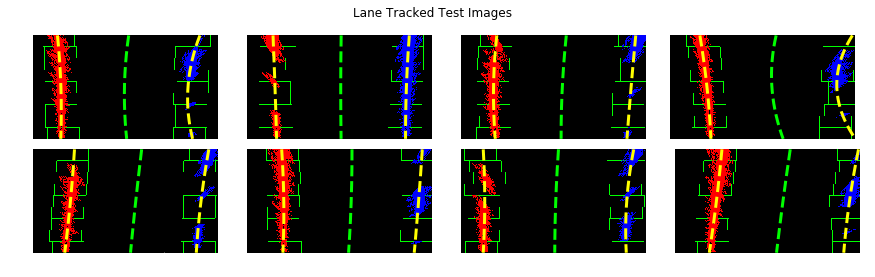

In [44]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Lane line detect using sliding-window histogram tracking
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom third of the image 
    #  (guard against curved lanes by looking at immediate road lines next to car front)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/3):,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 110
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    idx=0
    #print(leftx[idx], lefty[idx], rightx[idx], righty[idx])
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_fitx_m= left_fit_m[0]*ploty**2 + left_fit_m[1]*ploty + left_fit_m[2]
        right_fitx_m = right_fit_m[0]*ploty**2 + right_fit_m[1]*ploty + right_fit_m[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        left_fitx_m = 1*ploty**2 + 1*ploty
        right_fitx_m = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0] # red for left lane
    out_img[righty, rightx] = [0, 0, 255] # blue for right lane

    center_fitx = np.mean([left_fit[0],right_fit[0]])*ploty**2 + np.mean([left_fit[1],right_fit[1]])*ploty + np.mean([left_fit[2],right_fit[2]])
    #print(left_fit, right_fit)
    return out_img, left_fitx, right_fitx, center_fitx, left_fit_m, right_fit_m, left_fit, right_fit

# process warped image for line extraction
lanetracked_outimages = []
left_fitx = []
right_fitx = []
center_fitx = []
left_fit_m = []
right_fit_m = []
for index in range(len(warped_gradient_rhs_undistort_images)):
    binary_warped = warped_gradient_rhs_undistort_images[index]
    out_img, l_fitx, r_fitx, lr_fitx, l_fit_m, r_fit_m, _, _ = fit_polynomial(binary_warped[:,:,2])
    lanetracked_outimages.append(out_img)
    left_fitx.append(l_fitx)
    right_fitx.append(r_fitx)
    center_fitx.append(lr_fitx)
    left_fit_m.append(l_fit_m)
    right_fit_m.append(r_fit_m)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

# Plot the result
cols = 4
rows = int(len(lanetracked_outimages)/cols)
fig, axes = plt.subplots(rows, cols, figsize=(15,4))
plt.gcf()
plt.suptitle('Lane Tracked Test Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = cols * rows
for ax, index in zip(axes.flat, range(0,indexes)):    
    ax.imshow(lanetracked_outimages[index])
    # Plots the left and right polynomials on the lane lines
    ax.plot(left_fitx[index], ploty, color='yellow', linewidth=3, linestyle="--")
    ax.plot(right_fitx[index], ploty, color='yellow', linewidth=3, linestyle="--")
    ax.plot(center_fitx[index], ploty, color='lime', linewidth=3, linestyle="--") # average of left/right polynomial coeffs
    ax.axis('off')
plt.show()


#### 3.2.1 Using Previous Histogram Search Data

(720, 0)

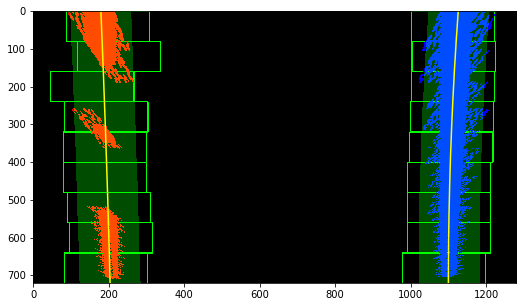

In [45]:
def fit_polynomial_using_prev(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # search "margin" pixels arpund previously detected polynomial 
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

# visualize the result on example image
margin = 80
binary_warped = warped_gradient_rhs_undistort_images[1]
out_img, _, _, _, _, _, left_fit, right_fit = fit_polynomial(binary_warped[:,:,2])    
left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = fit_polynomial_using_prev(binary_warped[:,:,2], left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
# previous polyfit
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# new polyfit
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
#print(out_img.shape)
#out_img = np.uint8(np.dstack((out_img, binary_warped[:,:,2], binary_warped[:,:,2]))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = binary_warped[:,:,2].nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
# Green lane marker from old polyfit
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
fig = plt.subplots(ncols=1, figsize=(15,5))
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### 3.3 Cross-correlation  Based Search

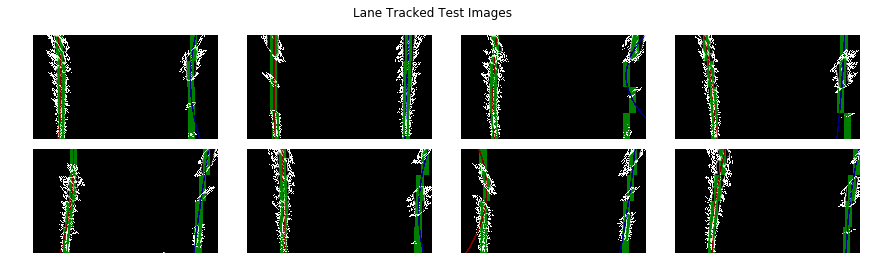

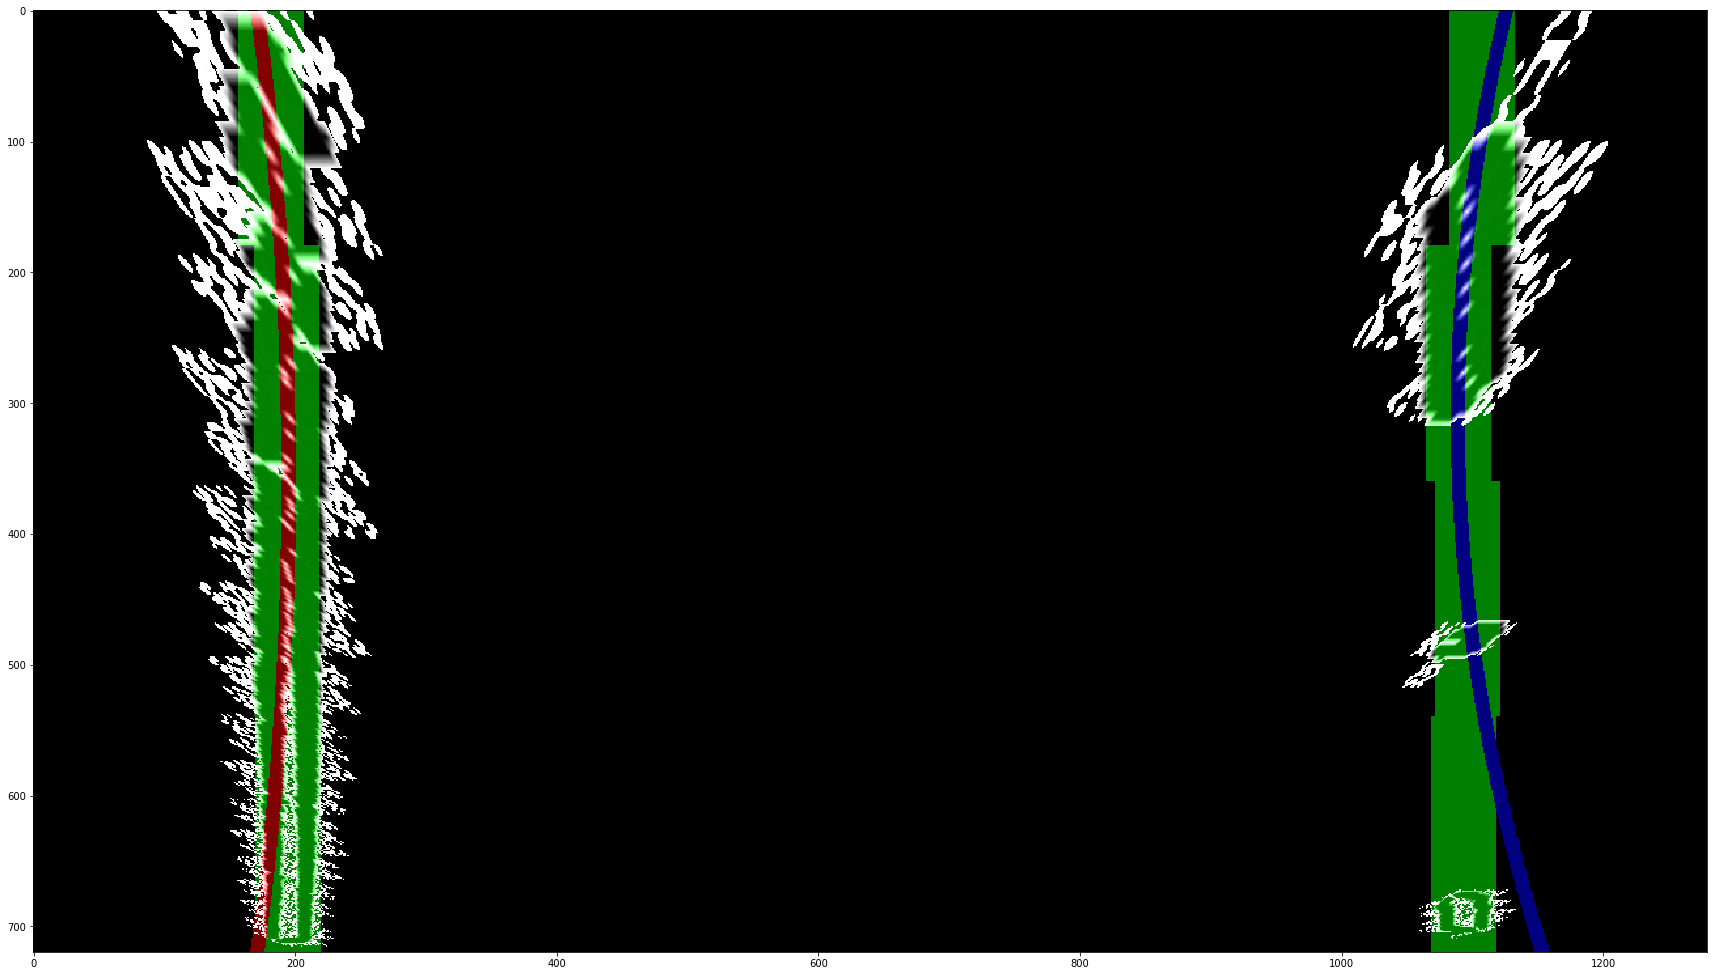

In [46]:
# Lane line detect using sliding-window histogram tracking
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # init
    leftx = []
    rightx = []
    polyy = []
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        #print(level, l_center,r_center)
        
        # Extract centroid x,y coordinates
        polyy.append((int(image.shape[0]-(level+1)*window_height) + int(image.shape[0]-level*window_height))/2)
        leftx.append(l_center)
        rightx.append(r_center)
        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(polyy, leftx, 2)
        right_fit = np.polyfit(polyy, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        # previous polyfit
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return window_centroids, left_fit, right_fit, left_fitx, right_fitx
    
window_width=50
window_height=180 #warped.size[0]//24
margin=170
lanetracked_outimages = []

for index in range(len(warped_gradient_rhs_undistort_images)):
    warped = warped_gradient_rhs_undistort_images[index][:,:,0]
    window_centroids, left_fit, right_fit, left_fitx, right_fitx = find_window_centroids(warped, window_width, window_height, margin)
    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        # convert to 3-channel array
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
        # left lane marker
        pts = np.vstack((left_fitx, ploty)).astype(np.int32).T
        cv2.polylines(template,  [pts],  isClosed=False,  color=(255, 0, 0),  thickness=10)
        # right lane marker
        pts = np.vstack((right_fitx, ploty)).astype(np.int32).T
        cv2.polylines(template,  [pts],  isClosed=False,  color=(0, 0, 255),  thickness=10)
        
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    lanetracked_outimages.append(output)
    
# Plot the result
cols = 4
rows = int(len(lanetracked_outimages)/cols)
fig, axes = plt.subplots(rows, cols, figsize=(15,4))
plt.gcf()
plt.suptitle('Lane Tracked Test Images')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = cols * rows
for ax, index in zip(axes.flat, range(0,indexes)):    
    ax.imshow(lanetracked_outimages[index])
    ax.axis('off')
plt.show()

plt.figure(figsize=(30,20))
plt.imshow(lanetracked_outimages[0])


In [47]:
# calculate lane curvature metrics
def measure_curvature_meters(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix  + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_meters(ploty, left_fit_m[0], right_fit_m[0])
print(left_curverad/1000, right_curverad/1000)
left_curverad, right_curverad = measure_curvature_meters(ploty, left_fit_m[1], right_fit_m[1])
print(left_curverad/1000, right_curverad/1000)


1.7041675769829656 0.37077326126080357
15.43332587157591 2.9627926317844326


***Warp lane markers to original Image*** 

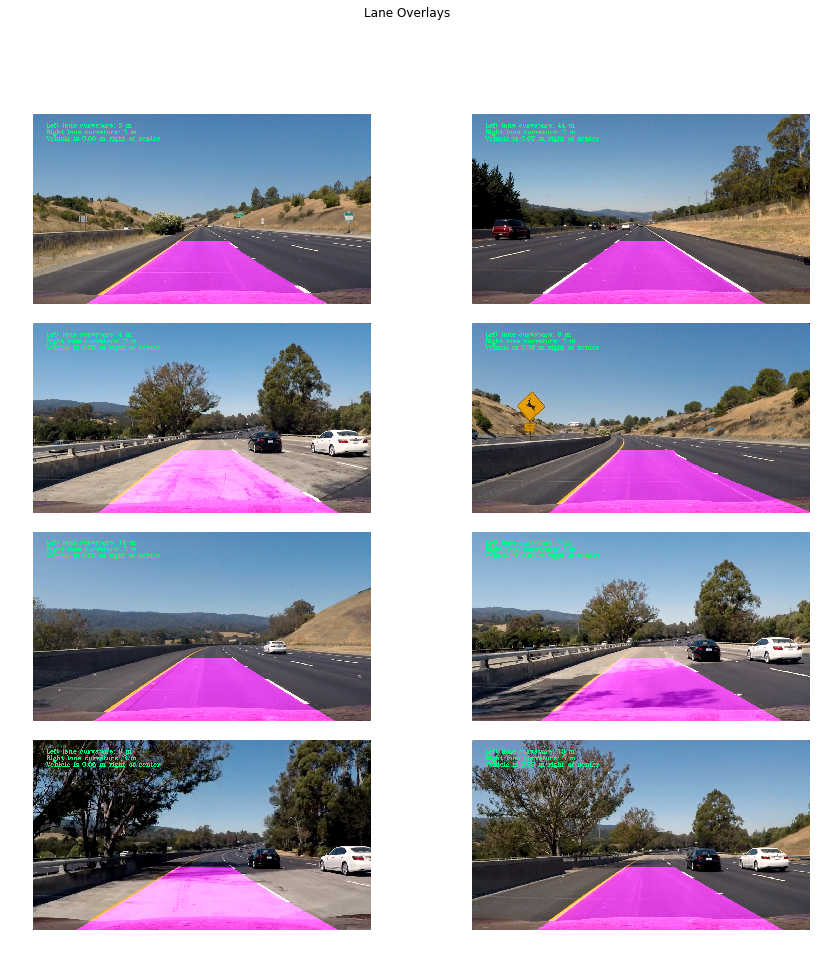

In [48]:
def drawLine(img, left_fit, right_fit):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.8, 0)

def drawLaneOnImage(img):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = fit_polynomial(img)
    output = drawLine(img, left_fit, right_fit)
    return cv2.cvtColor( output, cv2.COLOR_BGR2RGB )

def annotate_lanes (img, left_fit_m, right_fit_m, leftCurvature, rightCurvature, fontScale=.75):
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_COMPLEX
    fontColor = (124, 252, 0) #(255, 255, 255)
    cv2.putText(img, 'Left lane curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(img, 'Right lane curvature: {:.0f} m'.format(rightCurvature), (50, 75), font, fontScale, fontColor, 2)
    cv2.putText(img, 'Vehicle is {} of center'.format(message), (50, 100), font, fontScale, fontColor, 2)
     
    return img    
  
index = 0
output = []

files = os.listdir("./Resources/test_images/")
files2 = os.listdir("./Resources/test_images_warped_gradient_binary/")
for idx, fname in enumerate(files):
    img = cv2.imread("./Resources/test_images/"+fname)
    img2 = cv2.imread("./Resources/test_images_warped_gradient_binary/"+fname)
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    #left_fitx, left_fity, right_fitx, right_fity, out_img = find_lane_pixels(binary_warped)

    out_img, left_fitx, right_fitx, lr_fitx, l_fit_m, r_fit_m, left_fit, right_fit = fit_polynomial(img2[:,:,2])

    # Recast the x and y points into usable format for cv2.fillPoly()
    if (left_fit.size != 0):
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (255, 0, 255))

        # annotate frame
        left_curverad, rigfht_curverad = measure_curvature_meters(ploty, left_fit, right_fit)
        img = annotate_lanes (img, l_fit_m, r_fit_m, left_curverad/1e3, right_curverad/1e3, fontScale=.75)

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        output.append(cv2.addWeighted(img, 1, newwarp, 0.6, 0))

        # write annotated tets frames to files
        cv2.imwrite("./Resources/test_images_annotated_lanes/"+fname, output[index])
        index += 1
                
    
# Plot the result
cols = 2
rows = int(len(output)/cols)
fig, axes = plt.subplots(rows, cols, figsize=(15,15))
plt.gcf()
plt.suptitle('Lane Overlays')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = cols * rows
for ax, index in zip(axes.flat, range(0,indexes)):    
    ax.imshow(cv2.cvtColor(output[index],cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.show()


## 5. Video Processing Pipeline   

* Image undistort
* Color transform & level thresholding
* Gradient detector for edges
* Perspective transform to dewarp camera image
* Lane detect using historical tracking data
* Calculate curvature metrics
* Warp back to original image geometry

In [19]:
"""

#Importing packages required for notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from IPython.display import Markdown
import cv2
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
print("Packages imported ...")

# Load Camera Calibration Data
cameraData = pickle.load( open('./pickled_data/camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraData.get, ('mtx', 'dist'))
print("Loaded camera calibration data from file ...")

# Load camera warp data
transMatrix = pickle.load( open('./pickled_data/perspective_transform.p', 'rb' ) )
M, Minv = map(transMatrix.get, ('M', 'Minv'))
print("Loaded camera warp data from file ...")

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# global array to hold lane indicators across video frames
prev_left_lane_inds = []
prev_right_lane_inds = []

# Undistort image frame usign camera distorition matrix
def image_undistort (image):
    return cv2.undistort(image, mtx, dist, None, mtx) 
    
# Transform color space to HSL+RGB --> RHS component space
def color_transform (image):
    hls_img =cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return np.dstack((rgb_img[:,:,0], hls_img[:,:,0], hls_img[:,:,2]))
    #return np.dstack(( hls_img[:,:,2], hls_img[:,:,2], hls_img[:,:,2]))

# Level threshold RHS componenets per tuned threhold values
def color_threshold (image):
    r_thresh_min = 90
    r_thresh_max = 145
    h_thresh_min = 20
    h_thresh_max = 45
    s_thresh_min = 0
    s_thresh_max = 255    
    r_channel = image[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
    h_channel = image[:,:,1]
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1
    s_channel = image[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
 
    return (np.dstack(( r_binary, h_binary, s_binary))*255)
    
# Process RHS component images 
#  apply Sobel/Laplacian gradient thresholding (absolute, magnitude & angle)
def gradient_detect (s_channel, filter_type="sobel", kernel_size=3, abs_thresh=(0, 255), mag_thresh=(0, 255), angle_thresh=(0, np.pi/2)):
    
    # absolute thresholding
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if (filter_type == "sobel"):
        sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=kernel_size)
        sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=kernel_size)
    else: #"laplacian"
        sobelx = cv2.Laplacian(s_channel, cv2.CV_64F, ksize=kernel_size)
        sobely = cv2.Laplacian(s_channel, cv2.CV_64F, ksize=kernel_size)
    # Rescale back to 8 bit integer
    scaled_sobelx = np.uint8(255*np.absolute(sobelx)/np.max(np.absolute(sobelx)))
    scaled_sobely = np.uint8(255*np.absolute(sobely)/np.max(np.absolute(sobely)))
    # Create a copy and apply the threshold
    abs_binary_x = np.zeros_like(scaled_sobelx)
    abs_binary_y = np.zeros_like(scaled_sobely)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    abs_binary_x[(scaled_sobelx >= abs_thresh[0]) & (scaled_sobelx <= abs_thresh[1])] = 1
    abs_binary_y[(scaled_sobely >= abs_thresh[0]) & (scaled_sobely <= abs_thresh[1])] = 1

    # magnitude thresholding
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # angle thresholding
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= angle_thresh[0]) & (absgraddir <= angle_thresh[1])] = 1

    # generate combined thresholded S-channel image
    combined = np.zeros_like(dir_binary)
    combined[((abs_binary_x == 1) & (abs_binary_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255

    return combined.astype(np.uint8)

def gradient_threshold (image):
    #resultR = gradient_detect(image[:,:,0], filter_type="laplacian", abs_thresh=(20, 160), mag_thresh=(20, 160), angle_thresh=(0.5, np.pi/2))
    #resultH = gradient_detect(image[:,:,1], filter_type="laplacian", abs_thresh=(20, 160), mag_thresh=(20, 160), angle_thresh=(0.5, np.pi/2))
    resultS = gradient_detect(image[:,:,2], filter_type="sobel", abs_thresh=(20, 160), mag_thresh=(20, 160), angle_thresh=(0.5, np.pi/2))
    result = np.zeros_like(resultS)
    #result[((resultR == 255) & (resultH == 255)) | (resultS == 255)] = 255
    result = resultS
    
    return np.dstack((result, result, result))
    #return result.astype(np.uint8)

def warp_image (image):
    return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))

# Lane line detect using sliding-window histogram tracking
def find_lane_pixels (binary_warped, prev_left_lane_inds, prev_right_left_lane_inds):
    # Take a histogram of the bottom third of the image 
    #  (guard against curved lanes by looking at immediate road lines next to car front)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/3):,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 12
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        # Re-use lane indicators from last available frame
        left_lane_inds = prev_left_lane_inds
        right_lane_inds = prev_right_lane_inds
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds

def fit_polynomial (binary_warped, prev_left_lane_inds, prev_right_left_lane_inds):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, prev_left_lane_ids, prev_right_lane_inds = find_lane_pixels(binary_warped, prev_left_lane_inds, prev_right_left_lane_inds)

    idx=0
    #print(leftx[idx], lefty[idx], rightx[idx], righty[idx])
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_fitx_m= left_fit_m[0]*ploty**2 + left_fit_m[1]*ploty + left_fit_m[2]
        right_fitx_m = right_fit_m[0]*ploty**2 + right_fit_m[1]*ploty + right_fit_m[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        left_fitx_m = 1*ploty**2 + 1*ploty
        right_fitx_m = 1*ploty**2 + 1*ploty
    center_fitx = np.mean([left_fit[0],right_fit[0]])*ploty**2 + np.mean([left_fit[1],right_fit[1]])*ploty + np.mean([left_fit[2],right_fit[2]])

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0] # red for left lane
    out_img[righty, rightx] = [0, 0, 255] # blue for right lane
    ## draw lanelines & center track
    #out_img[ploty.astype(np.int64), left_fitx.astype(np.int64)] = [255, 255, 0] # yellow for left polynomial fit
    #out_img[ploty.astype(np.int64), right_fitx.astype(np.int64)] = [255, 255, 0] # yellow for right polynomial fit
    #out_img[ploty.astype(np.int64), center_fitx.astype(np.int64)] = [255, 255, 255] # yellow for road center 

    return out_img, ploty, left_fitx, right_fitx, center_fitx, left_fit_m, right_fit_m

def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in kilometers.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad/1000., right_curverad/1000.

def draw_lane_lines (img, left_fitx, right_fitx):
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def annotate_lanes (img, left_fit_m, right_fit_m, leftCurvature, rightCurvature, fontScale=.75):
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_COMPLEX
    fontColor = (124, 252, 0) #(255, 255, 255)
    cv2.putText(img, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(img, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 75), font, fontScale, fontColor, 2)
    cv2.putText(img, 'Vehicle is {} of center'.format(message), (50, 100), font, fontScale, fontColor, 2)
     
    return img    
    
def draw_lanes_on_image (img, left_fitx, right_fitx, left_fit_m, right_fit_m, leftCurvature, rightCurvature):
    
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)


def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width=50, window_height=50, margin=100):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

def roi_mask (img, maskfit_factor_horiz=2.5, maskfit_factor_vert=1.67):
    # define region of interest, 4-sided polygon
    ysize = img.shape[0]
    xsize = img.shape[1]
    left_bottom = np.array([0, ysize])
    right_bottom = np.array([xsize, ysize])
    # check ROI top vertices don't cross
    if (xsize/maskfit_factor_horiz < xsize/2):
        left_top = np.array([xsize/maskfit_factor_horiz, ysize/maskfit_factor_vert])
        right_top = np.array([xsize-xsize/maskfit_factor_horiz, ysize/maskfit_factor_vert])
    else:
        left_top = np.array([xsize/2, ysize/maskfit_factor_vert])
        right_top = np.array([xsize/2, ysize/maskfit_factor_vert])
    roi_vertices = np.array([[left_bottom,left_top,right_top,right_bottom]], dtype=np.int32)
    
    # apply mask
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, roi_vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    img = cv2.bitwise_and(img, mask)

    return img

def VideoLaneTrackingPipeline(image):
    img = image_undistort(image)
    img = color_transform(img)
    img = color_threshold(img)
    img = gradient_threshold(img)
    #img = warp_image(img)
    #img, ploty, l_fitx, r_fitx, lr_fitx, l_fit_m, r_fit_m = fit_polynomial(img[:,:,2], prev_left_lane_inds, prev_left_lane_inds)
    #left_curverad, right_curverad = measure_curvature_real(ploty, l_fit_m, r_fit_m)
    #print('Left : {:.2f} km, Right : {:.2f} km'.format(left_curverad, right_curverad))
    
    #img = draw_lane_lines(image, l_fitx, r_fitx)
    ##img = draw_lanes_on_image (image, l_fitx, r_fitx, l_fit_m, r_fit_m, left_curverad, right_curverad)
    #img = annotate_lanes(img, l_fit_m, r_fit_m, left_curverad, right_curverad)

    return img
"""

"""
#
# Process images in test directory
#
out_images = []
files = os.listdir("./test_images/")
for file in files:
    iimg = cv2.imread("./test_images/"+file)
    oimg = VideoLaneTrackingPipeline(iimg)
    out_images.append(oimg)
    cv2.imwrite('./output_images/'+file, oimg) 

imgLength = len(out_images)
rows = 2
cols = int(len(out_images)/rows)
fig, axes = plt.subplots(rows, cols, figsize=(15,4))
plt.suptitle('Test Images With Lane Markers')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):    
    ax.imshow(cv2.cvtColor(out_images[index], cv2.COLOR_BGR2RGB))
    #ax.imshow(out_images[index], cmap='gray')
    ax.axis('off')
"""
    
"""
#
# Process videos in test directory
#
files = os.listdir("./test_videos/")
for file in files:
    video_output = "./test_videos_output/"+file    
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    clip1 = VideoFileClip("./test_videos/"+file).subclip(5,10)
    #clip1.reader.close()
    #clip1.audio.reader.close_proc()
    #clip1.close()
    video_clip = clip1.fl_image(VideoLaneTrackingPipeline) #NOTE: this function expects color images!!
    #video_clip = clip1
    %time video_clip.write_videofile(video_output, audio=False)
    del clip1
    """

'\n#\n# Process videos in test directory\n#\nfiles = os.listdir("./test_videos/")\nfor file in files:\n    video_output = "./test_videos_output/"+file    \n    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video\n    ## To do so add .subclip(start_second,end_second) to the end of the line below\n    ## Where start_second and end_second are integer values representing the start and end of the subclip\n    clip1 = VideoFileClip("./test_videos/"+file).subclip(5,10)\n    #clip1.reader.close()\n    #clip1.audio.reader.close_proc()\n    #clip1.close()\n    video_clip = clip1.fl_image(VideoLaneTrackingPipeline) #NOTE: this function expects color images!!\n    #video_clip = clip1\n    %time video_clip.write_videofile(video_output, audio=False)\n    del clip1\n    '